## Ocean with periodic boundary

In [3]:
# import a bunch of packages - don't worry about TF warnings
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
#import seaborn as sns
import pickle
#from src.score import *
from collections import OrderedDict

In [2]:
# mount google drive to colab
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# path to shared folder - containing relevant data
#root_era5 = '/content/drive/MyDrive/2024METFUT_project_data/ERA5/'
root_era5  = '/home/anton/Documents/MSPEA/SoSe24/MachineLearning/data_retrieval/2024METFUT_project_data/ERA5/'

# import the sea surface temperature, sea ice concentration, land-sea-mask
sst    = xr.open_mfdataset(root_era5+'sst_5.625deg/*.nc', combine='by_coords').load()
siconc = xr.open_mfdataset(root_era5+'siconc_5.625deg/*.nc', combine='by_coords').load()

In [43]:
lsm    = xr.open_dataset(root_era5+'lsm_5.625deg.nc').load()
lsm

<xarray.Dataset> Size: 17kB
Dimensions:    (longitude: 64, latitude: 33, time: 1)
Coordinates:
  * longitude  (longitude) float32 256B 0.0 5.625 11.25 ... 343.1 348.8 354.4
  * latitude   (latitude) float32 132B 90.0 84.38 78.75 ... -78.75 -84.38 -90.0
  * time       (time) datetime64[ns] 8B 1979-01-01T09:00:00
Data variables:
    lsm        (time, latitude, longitude) float64 17kB 0.0 0.0 0.0 ... 1.0 1.0
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-30 13:38:58 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [55]:
xr.where(lsm>0.5,0,1)['lsm'].values[0,:,:].shape

(33, 64)

In [8]:
# create daily climatology
sst_clim    = sst.groupby('time.dayofyear').mean()
siconc_clim = siconc.groupby('time.dayofyear').mean()

# fill nan values in datasets - otherwise no learning possible
sst = sst.fillna(sst_clim.sel(dayofyear=sst.time.dt.dayofyear))
siconc = siconc.fillna(siconc_clim.sel(dayofyear=siconc.time.dt.dayofyear))

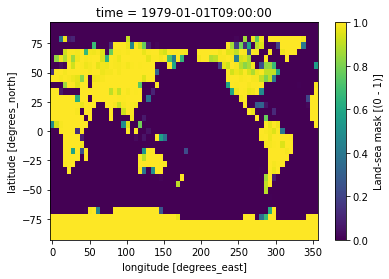

In [9]:
lsm.lsm.isel(time=0).plot()

In [10]:
# create strict land sea mask
slm = xr.where(lsm>0.5,0,1)['lsm'].values[0,:,:]
lsm = xr.where(lsm<0.5,0,1)['lsm'].values[0,:,:]

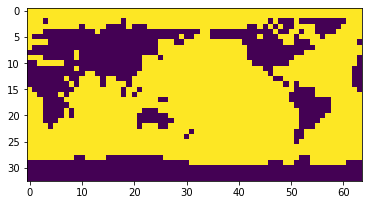

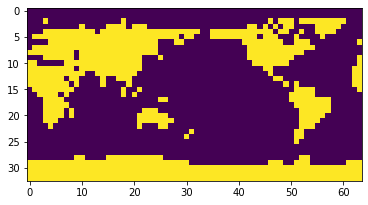

In [11]:
plt.imshow(slm)
plt.show()
plt.imshow(lsm)
plt.show()

## create the training data

In [12]:
data = xr.merge([sst, siconc])

In [13]:
# training dataset selection
train_years = slice('1979', '1982')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('1982', '1983')
# test dataset selection
test_years = slice('1983', '1984')

In [14]:
# pick the forecast lead time
lead_time_steps = 5 # 5 day forecast considering one time step

In [15]:
def get_train_valid_test_dataset(lead_steps, datasets, variables):
  # create lists
  X_train = []
  Y_train = []
  X_valid = []
  Y_valid = []
  X_test  = []
  Y_test  = []
  mean    = np.zeros(len(datasets))
  std     = np.zeros(len(datasets))

  # iterate over index
  for i, d in enumerate(datasets):

    # Split train, valid and test dataset
    train_d = d.sel(time=train_years)
    valid_d = d.sel(time=valid_years)
    test_d  = d.sel(time=test_years)

    # Normalize the data using the mean and standard deviation of the training data
    mean[i] = d.mean()[variables[i]].values
    std[i]  = d.std()[variables[i]].values

    train_d = (train_d - mean[i]) / std[i]
    valid_d = (valid_d - mean[i]) / std[i]
    test_d  = (test_d  - mean[i]) / std[i]

    #mean = mean['sst'].values # extract numerical value from xarray Dataset
    #std = std['sst'].values # extract numerical value from xarray Dataset

    # Create inputs and outputs that are shifted by lead_steps
    X_train.append(getattr(train_d, variables[i]).isel(time=slice(None, -lead_steps)).values[..., None])
    Y_train.append(getattr(train_d, variables[i]).isel(time=slice(lead_steps, None)).values[..., None])
    X_valid.append(getattr(valid_d, variables[i]).isel(time=slice(None, -lead_steps)).values[..., None])
    Y_valid.append(getattr(valid_d, variables[i]).isel(time=slice(lead_steps, None)).values[..., None])
    X_test.append(getattr(test_d, variables[i]).isel(time=slice(None, -lead_steps)).values[..., None])
    Y_test.append(getattr(test_d, variables[i]).isel(time=slice(lead_steps, None)).values[..., None])

  # concatenate training data for multi layer input
  X_train = np.concatenate(X_train, axis = 3)
  Y_train = np.concatenate(Y_train, axis = 3)
  X_valid = np.concatenate(X_valid, axis = 3)
  Y_valid = np.concatenate(Y_valid, axis = 3)
  X_test  = np.concatenate(X_test, axis = 3)
  Y_test  = np.concatenate(Y_test, axis = 3)

  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

In [16]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, [sst, siconc], ['sst', 'siconc'])
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(1456, 33, 64, 2)
(1456, 33, 64, 2)
(725, 33, 64, 2)
(725, 33, 64, 2)
(726, 33, 64, 2)
(726, 33, 64, 2)


## Periodic CNN Network
Copy multiple classes from weatherBench publication

In [17]:
class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config


class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

# outside of Class
def build_cnn(filters, kernels, input_shape, dr=0):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        x = PeriodicConv2D(f, k)(x)
        x = LeakyReLU()(x)
        if dr > 0: x = Dropout(dr)(x)
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    return keras.models.Model(input, output)

In [18]:
# set up test model
#test_model = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (33, 64, 2))
#test_model.compile(keras.optimizers.Adam(1e-4), 'mse')
#test_model.summary()

In [19]:
# try to feed training data
#test_model.fit(X_train, Y_train, batch_size= 128, epochs=1)

In [20]:
# Convert predictions backto xarray
#pred_test = X_test[:, :, :, :].copy()
#pred_test = test_model.predict(X_test[0:2,:,:,:])#.squeeze()   # To remove channel dimension which is 1

In [21]:
#plt.imshow(pred_test[1,:,:,0]*slm)

## create personal loss function

In [22]:
K.constant(np.stack([lsm,lsm],axis=2)).shape

TensorShape([33, 64, 2])

In [23]:
def lsm_loss(y_true, y_pred, lsm=slm):
  #print(y_true.shape)
  lsm = K.constant(np.stack([lsm,lsm],axis=2))
  y_true = y_true * lsm
  y_pred = y_pred * lsm

  return K.sqrt(K.mean(K.square(y_true-y_pred)))

In [25]:
#lsm_loss(pred_test[0,:,:,:], pred_test[0,:,:,:]+1)

In [26]:
# another test model
#test_model_mask = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (33, 64, 2))
#test_model_mask.compile(keras.optimizers.Adam(1e-4), loss=lsm_loss)
#test_model_mask.summary()

In [27]:
# try to feed training data
#test_model_mask.fit(X_train, Y_train, batch_size= 128, epochs=1)

In [28]:
#pred_test_mask = test_model_mask.predict(X_test[0:2,:,:,:])

In [29]:
#plt.imshow(pred_test_mask[1,:,:,1]*slm)
#plt.show()
#plt.imshow(pred_test[1,:,:,1]*slm)

In [30]:
#plt.imshow(slm)

In [31]:
# What needds to be changed for 4D input and output
test_model_4D = build_cnn([64, 64, 64, 64, 4], [5, 5, 5, 5, 5], (33, 64, 4))
test_model_4D.compile(keras.optimizers.Adam(1e-4), loss=lsm_loss)
test_model_4D.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33, 64, 4)]       0         
                                                                 
 periodic_conv2d (PeriodicC  (None, 33, 64, 64)        6464      
 onv2D)                                                          
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 33, 64, 64)        0         
                                                                 
 periodic_conv2d_1 (Periodi  (None, 33, 64, 64)        102464    
 cConv2D)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 33, 64, 64)        0         
                                                                 
 periodic_conv2d_2 (Periodi  (None, 33, 64, 64)        102464

In [32]:
# Does it make sense to create Classes for Ocean/Land/Atmosphere and complete set up?

In [33]:
test_model_eff = build_cnn([64, 2], [5, 5], (33, 64, 2))
test_model_eff.compile(keras.optimizers.Adam(1e-4), loss=lsm_loss)
test_model_eff.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33, 64, 2)]       0         
                                                                 
 periodic_conv2d_5 (Periodi  (None, 33, 64, 64)        3264      
 cConv2D)                                                        
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 33, 64, 64)        0         
                                                                 
 periodic_conv2d_6 (Periodi  (None, 33, 64, 2)         3202      
 cConv2D)                                                        
                                                                 
Total params: 6466 (25.26 KB)
Trainable params: 6466 (25.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
test_model_eff.fit(X_train, Y_train, batch_size= 128, epochs=5)

Epoch 1/5
12/12 [==============================] - 30s 2s/step - loss: 0.7716
Epoch 2/5
12/12 [==============================] - 29s 2s/step - loss: 0.5729
Epoch 3/5
12/12 [==============================] - 27s 2s/step - loss: 0.4455
Epoch 4/5
12/12 [==============================] - 29s 2s/step - loss: 0.3746
Epoch 5/5
12/12 [==============================] - 26s 2s/step - loss: 0.3265


In [ ]:
# run model multiple times and save development of RMSE for validation/training dataset

In [38]:
pred_valid_model_eff = test_model_eff.predict(X_valid)

23/23 [==============================] - 4s 160ms/step


In [65]:
diff = pred_valid_model_eff*np.stack([lsm,lsm],axis=2)-Y_valid*np.stack([lsm,lsm],axis=2)

In [81]:
np.sqrt(np.mean(np.square(diff[:,:,:,:])))

0.41650876868464715

In [75]:
rmse_train = []
rmse_valid = []

rmse_train_var = [[],[]]
rmse_valid_var = [[],[]]

In [89]:
for i in range(5):
  # keep on training the model
  test_model_eff.fit(X_train, Y_train, batch_size= 128, epochs=5)

  # predict
  pred_train = test_model_eff.predict(X_train)
  pred_valid = test_model_eff.predict(X_valid)

  # apply mask and compute residuals
  e_train = pred_train*np.stack([lsm,lsm],axis=2)-Y_train*np.stack([lsm,lsm],axis=2)
  e_valid = pred_valid*np.stack([lsm,lsm],axis=2)-Y_valid*np.stack([lsm,lsm],axis=2)

  # compute rmse overall
  rmse_train.append(np.sqrt(np.mean(np.square(e_train))))
  rmse_valid.append(np.sqrt(np.mean(np.square(e_valid))))

  # rmse for seperate variables
  for v in range(2):
    rmse_train_var[v].append(np.sqrt(np.mean(np.square(e_train[:,:,:,v]))))
    rmse_valid_var[v].append(np.sqrt(np.mean(np.square(e_valid[:,:,:,v]))))

Epoch 1/5
12/12 [==============================] - 28s 2s/step - loss: 0.0863
Epoch 2/5
12/12 [==============================] - 27s 2s/step - loss: 0.0861
Epoch 3/5
12/12 [==============================] - 28s 2s/step - loss: 0.0859
Epoch 4/5
12/12 [==============================] - 28s 2s/step - loss: 0.0857
Epoch 5/5
23/23 [==============================] - 3s 118ms/step
Epoch 1/5
12/12 [==============================] - 27s 2s/step - loss: 0.0854
Epoch 2/5
12/12 [==============================] - 27s 2s/step - loss: 0.0852
Epoch 3/5
12/12 [==============================] - 25s 2s/step - loss: 0.0851
Epoch 4/5
12/12 [==============================] - 27s 2s/step - loss: 0.0849
Epoch 5/5
23/23 [==============================] - 2s 90ms/step
Epoch 1/5
12/12 [==============================] - 26s 2s/step - loss: 0.0847
Epoch 2/5
12/12 [==============================] - 26s 2s/step - loss: 0.0846
Epoch 3/5
12/12 [==============================] - 27s 2s/step - loss: 0.0845
Epoch 4/5
12/

In [90]:
rmse_valid, rmse_train

([0.41650876868464715,
  0.31805273622829355,
  0.28215026713992347,
  0.249501735310279,
  0.21756147019848726,
  0.18806905608804816,
  0.16272018615341707,
  0.14325672420282168,
  0.12882883169244502,
  0.11864016078909229,
  0.11118325922769587,
  0.1051737212849208,
  0.10106855683292454,
  0.0974282975656895,
  0.0945393996574647,
  0.09229507733287844],
 [0.41464379808474394,
  0.3162449505111048,
  0.280709923695233,
  0.24823942243919503,
  0.21640086193980873,
  0.18699008945870033,
  0.16172544853775045,
  0.14234780186974402,
  0.12799438628455234,
  0.11787143633864389,
  0.11047134289816402,
  0.1045134265517733,
  0.1004480103566061,
  0.09684300260710384,
  0.09398171178051591,
  0.09175671315011465])

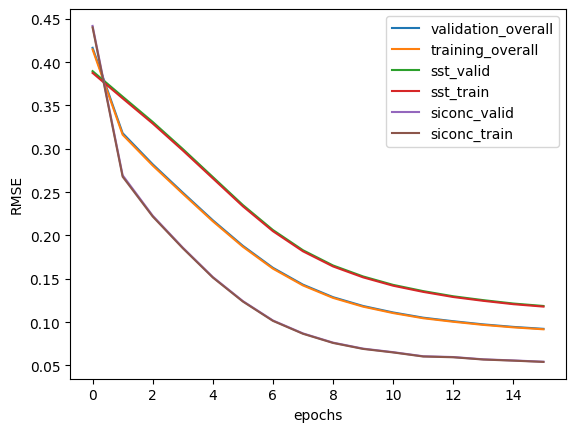

In [124]:
plt.plot(rmse_valid, label='validation_overall')
plt.plot(rmse_train, label='training_overall')
plt.plot(rmse_valid_var[0], label='sst_valid')
plt.plot(rmse_train_var[0], label='sst_train')
plt.plot(rmse_valid_var[1], label='siconc_valid')
plt.plot(rmse_train_var[1], label='siconc_train')
plt.ylabel('RMSE')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [121]:
rmse_valid[5]==np.sqrt((rmse_valid_var[0][5]**2+rmse_valid_var[1][5]**2)/2)

True

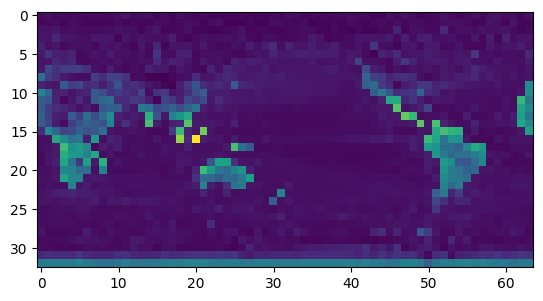

In [123]:
plt.imshow(np.mean(np.abs((pred_train[:,:,:,0]-Y_train[:,:,:,0])),axis=0))

In [107]:
lsm_loss(np.stack([lsm,lsm],axis=2)*100,np.stack([lsm,lsm],axis=2),lsm=slm)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

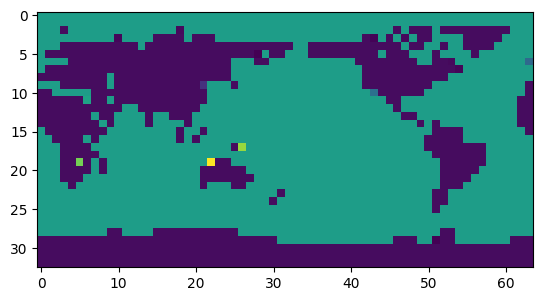

In [113]:
plt.imshow(X_train[0,:,:,0]*lsm)

In [66]:
from CNN_architecture import *

In [68]:
data_ocean = data_prep(root_era5, 5)

In [65]:
data_ocean.

AttributeError: 'data_prep' object has no attribute 'ocean'